<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам

# <center>Неделя 7. Финальный проект
    
### <center> На основе соревнования - https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/overview

Основные шаги:

* цели и задачи проекта, описание исходных и обработанных данных и признаков.
* первичный анализ признаков
* первичный визуальный анализ признаков
* если пришли к каким-то "инсайтам", обнаружили закономерности – изложите
* описание предобработки данных
* если создаются признаки, то описание этого процесса
* кросс-валидация, построение кривых валидации и обучения
* оценка модели с описанием выбранной метрики. Опишите простыми словами качество модели, как она может применяться
* выводы: как построенная модель может применяться на практике, какие бизнес-задачи решать. Подведите итог, опишите, что еще можно сделать, а что сделать не удалось.


### Задание
Отчет должен быть выполнен в формате pdf или тетрадки Jupyter, но вообще и тут мало что ограничивает фантазию, Вы можете придумать свой вариант. 

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
import seaborn as sns
%matplotlib inline
from scipy.sparse import csr_matrix, hstack, vstack
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from matplotlib.ticker import PercentFormatter

**Считаем данные [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) в DataFrame train_df и test_df (обучающая и тестовая выборки).**

In [2]:
PATH_TO_DATA = 'data'

In [3]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id')

In [4]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,3846.0,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,39.0,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,782.0,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,178.0,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


**Объединим обучающую и тестовую выборки – это понадобится, чтоб вместе потом привести их к разреженному формату.**

In [5]:
train_test_df = pd.concat([train_df, test_df])

В обучающей выборке train_sessions.csv:

* Признаки site_i – это индексы посещенных сайтов (расшифровка дана в pickle-файле со словарем site_dic.pkl)
* Признаки time_j – время посещения сайтов site_j
* Целевой признак target – факт того, что сессия принадлежит Элис (то есть что именно Элис ходила по всем этим сайтам)

Задача – сделать прогнозы для сессий в тестовой выборке (test_sessions.csv), определить, принадлежат ли они Элис. Не обязательно ограничиваться только предложенной выборкой train_sessions.csv – в train.zip даны исходные данные о посещенных пользователями веб-страницах, по которым можно сформировать свою обучающую выборку.

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
site1     253561 non-null int64
time1     253561 non-null object
site2     250098 non-null float64
time2     250098 non-null object
site3     246919 non-null float64
time3     246919 non-null object
site4     244321 non-null float64
time4     244321 non-null object
site5     241829 non-null float64
time5     241829 non-null object
site6     239495 non-null float64
time6     239495 non-null object
site7     237297 non-null float64
time7     237297 non-null object
site8     235224 non-null float64
time8     235224 non-null object
site9     233084 non-null float64
time9     233084 non-null object
site10    231052 non-null float64
time10    231052 non-null object
target    253561 non-null int64
dtypes: float64(9), int64(2), object(10)
memory usage: 42.6+ MB


In [7]:
test_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,2014-12-05 15:56:16,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,2014-11-04 10:03:21,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,2014-05-16 15:05:40,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82797 entries, 1 to 82797
Data columns (total 20 columns):
site1     82797 non-null int64
time1     82797 non-null object
site2     81308 non-null float64
time2     81308 non-null object
site3     80075 non-null float64
time3     80075 non-null object
site4     79182 non-null float64
time4     79182 non-null object
site5     78341 non-null float64
time5     78341 non-null object
site6     77566 non-null float64
time6     77566 non-null object
site7     76840 non-null float64
time7     76840 non-null object
site8     76151 non-null float64
time8     76151 non-null object
site9     75484 non-null float64
time9     75484 non-null object
site10    74806 non-null float64
time10    74806 non-null object
dtypes: float64(9), int64(1), object(10)
memory usage: 13.3+ MB


**В обучающей выборке – 2297 сессий одного пользователя (Alice) и 251264 сессий – других пользователей, не Элис. Дисбаланс классов очень сильный, и смотреть на долю верных ответов (accuracy) непоказательно.**

In [9]:
train_df['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

**Пока для прогноза будем использовать только индексы посещенных сайтов. Индексы нумеровались с 1, так что заменим пропуски на нули.**

In [10]:
train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')

In [11]:
train_test_df_sites.head(10)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
1,718,0,0,0,0,0,0,0,0,0
2,890,941,3847,941,942,3846,3847,3846,1516,1518
3,14769,39,14768,14769,37,39,14768,14768,14768,14768
4,782,782,782,782,782,782,782,782,782,782
5,22,177,175,178,177,178,175,177,177,178
6,570,21,570,21,21,0,0,0,0,0
7,803,23,5956,17513,37,21,803,17514,17514,17514
8,22,21,29,5041,14422,23,21,5041,14421,14421
9,668,940,942,941,941,942,940,23,21,22


In [12]:
times = ['time%s' % i for i in range(1, 11)]
sites = ['site%s' % i for i in range(1, 11)]

In [13]:
train_set = set()
for site in sites:
    st = set(list(train_df[site].dropna().values.astype(int)))
    train_set = train_set | st

In [14]:
len(train_set)

41601

In [15]:
test_set = set()
for site in sites:
    st = set(list(test_df[site].dropna().values.astype(int)))
    test_set = test_set | st

In [16]:
len(test_set)

15857

In [17]:
# Составим список сайтов встречающихся и в тестовой, и в обучающей выборках
train_AND_test_sites = train_set & test_set

# Заменим на нули индексы сайтов, которые встречаются либо только в обучающей, либо только в тествовой выборках
train_test_df_sites = train_test_df_sites * train_test_df_sites.isin(train_AND_test_sites)

# Чтобы уменьшить размер разреженной матрицы, перенумеруем сайты
# Составим словарь сайтов, где значение соответствеут номеру по частоте встечаемости
site_counts = pd.value_counts(train_test_df_sites.values.flatten())
sites_num = len(site_counts)
site2site = dict(zip(site_counts.index,range(sites_num)))

# На всякий случай убедимся, что 0 - самый частый индекс сайта в таблице
print("0 = 0:",site2site[0]==0)

#print("Число сайтов встречающихся и в обучающей, и в тестовой выборке:", sites_num-1)

# Перенумеруем сайты и фразы в таблице
train_test_df_sites = train_test_df_sites.applymap(lambda x: site2site[x])

0 = 0: True


In [18]:
%%time
train_test_sparse = csr_matrix(([1]*train_test_df_sites.size,np.array(train_test_df_sites).flatten(),
                               range(0,train_test_df_sites.size+1,train_test_df_sites.shape[1])))[:,1:]

X_train_sparse = train_test_sparse[:len(train_df)]
X_test_sparse = train_test_sparse[len(train_df):]
y = train_df.target.values

Wall time: 360 ms


In [19]:
print('X_train_sparse dimensionality:')
print(X_train_sparse.shape)
print('X_test_sparse dimensionality:')
print(X_test_sparse.shape)

X_train_sparse dimensionality:
(253561, 9087)
X_test_sparse dimensionality:
(82797, 9087)


**Сохраним в pickle-файлы объекты *X_train_sparse*, *X_test_sparse* и *y* (последний – в файл *kaggle_data/train_target.pkl*).**

**Разобьем обучающую выборку на 2 части в пропорции 7/3, причем не перемешивая. Исходные данные упорядочены по времени, тестовая выборка по времени четко отделена от обучающей, это же соблюдем и здесь.**

In [20]:
train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]

**Создаем объект `sklearn.linear_model.SGDClassifier` с логистической функцией потерь и параметром *random_state*=42. Остальные параметры оставьте по умолчанию, разве что *n_jobs*=-1 никогда не помешает. Обучите  модель на выборке `(X_train, y_train)`.**

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, validation_curve, train_test_split,\
                                    StratifiedKFold, GridSearchCV

In [22]:
%%time
sgd_logit = SGDClassifier(loss='log', n_jobs=-1, random_state=42)
sgd_logit.fit(X_train, y_train)

Wall time: 303 ms


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [23]:
logit_valid_pred_proba = sgd_logit.predict_proba(X_valid)

In [24]:
print('ROC AUC:')
print (round(roc_auc_score(y_valid, logit_valid_pred_proba[:,1]), 3))

ROC AUC:
0.93


## Часть 2. Создание новых признаков

**Создаем функцию для определения времени нахождения на сайте и общего времени сессии, признаки день недели, час начала сессии**

In [25]:
times = ['time%s' % i for i in range(1, 11)]
sites = ['site%s' % i for i in range(1, 11)]

In [26]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,3846.0,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,39.0,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,782.0,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,178.0,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [27]:
def feature_ingeneering(sessions):

    new_features = pd.DataFrame()
    
    timestamps = sessions[['time%s' % i for i in range(1, 11)]]
    sites = sessions[['site%s' % i for i in range(1, 11)]].fillna(0).astype(int).values

    for td_index in range(1, 10):
        new_features['time_diff{}'.format(td_index)] = (pd.to_datetime(timestamps['time{}'.format(td_index + 1)]) - 
                                                pd.to_datetime(timestamps['time{}'.format(td_index)])
                                               ).dt.total_seconds().fillna(0)
    
    new_features['session_timespan'] = np.sum(new_features, axis=1)
    new_features['start_hour'] = pd.to_datetime(timestamps['time1']).dt.hour
    new_features['day_of_week'] = pd.to_datetime(timestamps['time1']).dt.weekday
    new_features['unique_sites'] = [len(np.unique(session[session != 0])) for session in sites]

    return new_features

In [28]:
train_test_new = feature_ingeneering(train_df)

In [29]:
train_test_new.head()

,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,start_hour,day_of_week,unique_sites
session_id,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,3,1
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,23.0,1.0,26.0,11,5,7
3,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,7.0,16,0,4
4,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,270.0,10,4,1
5,137.0,0.0,1.0,0.0,36.0,0.0,0.0,67.0,5.0,246.0,10,4,4


## Часть 3. Визуальный анализ данных

**Графики распределения длины сессии в секундах, часа начала сессии, дня недели, числа уникальных сайтов**

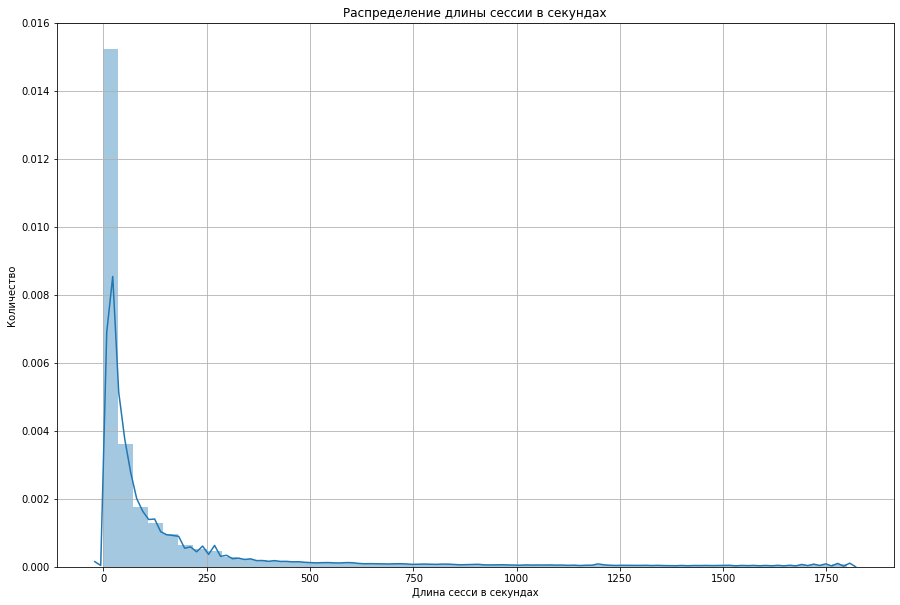

In [30]:
plt.figure(figsize=(15, 10))
sns.distplot(train_test_new['session_timespan'])

plt.xlabel('Длина сесси в секундах')
plt.ylabel('Количество')
plt.title('Распределение длины сессии в секундах')
plt.grid(True)
plt.show()

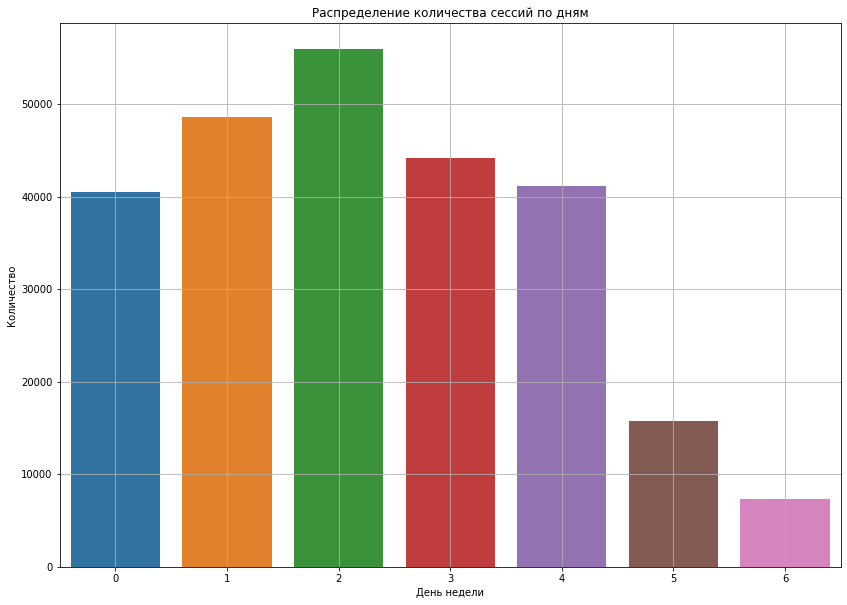

In [31]:
plt.figure(figsize=(14, 10))
sns.countplot(x=train_test_new['day_of_week'].values, data=train_test_new)

plt.xlabel('День недели')
plt.ylabel('Количество')
plt.title('Распределение количества сессий по дням')
plt.grid(True)
plt.show()

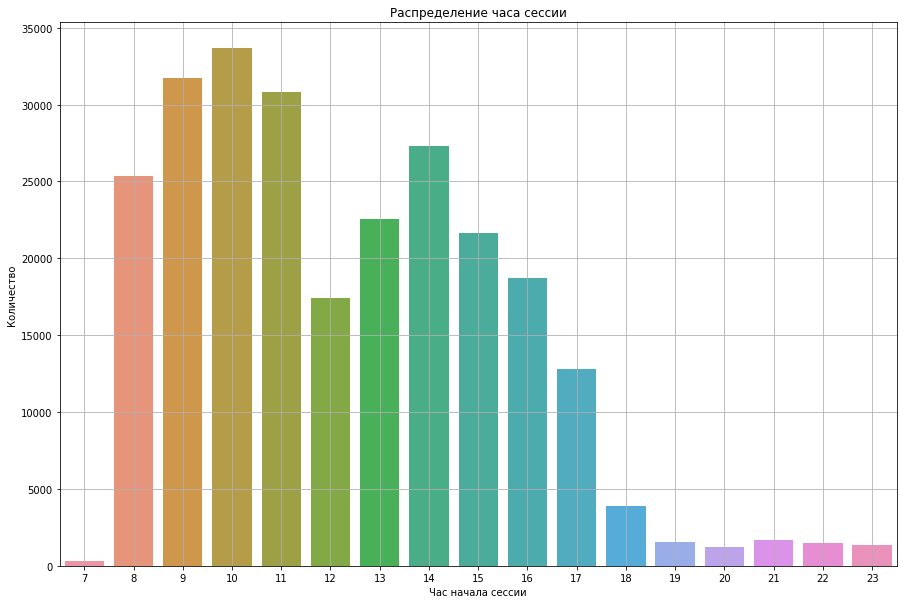

In [32]:
plt.figure(figsize=(15, 10))
sns.countplot(x='start_hour', data=train_test_new)

plt.xlabel('Час начала сессии')
plt.ylabel('Количество')
plt.title('Распределение часа сессии')
plt.grid(True)
plt.show()

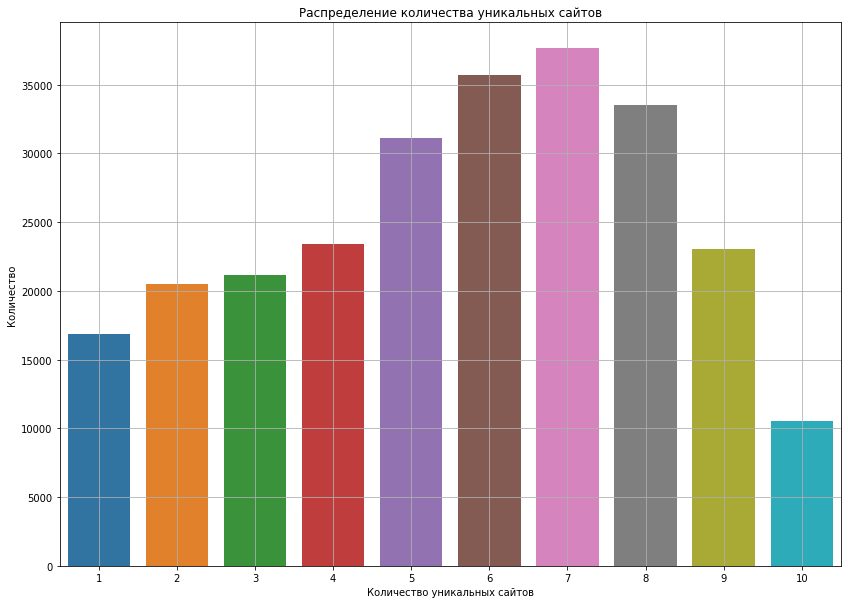

In [33]:
plt.figure(figsize=(14, 10))
sns.countplot(x=train_test_new['unique_sites'].values, data=train_test_new)

plt.xlabel('Количество уникальных сайтов')
plt.ylabel('Количество')
plt.title('Распределение количества уникальных сайтов')
plt.grid(True)
plt.show()

## Часть 4. Предобработка данных

In [34]:
train_test_new.head()

,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,start_hour,day_of_week,unique_sites
session_id,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,3,1
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,23.0,1.0,26.0,11,5,7
3,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,7.0,16,0,4
4,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,270.0,10,4,1
5,137.0,0.0,1.0,0.0,36.0,0.0,0.0,67.0,5.0,246.0,10,4,4


In [35]:
train_test_new_numeric = train_test_new.loc[:, :'session_timespan']
train_test_new_dummy = train_test_new.loc[:, 'start_hour':]

In [36]:
train_test_new_numeric.head()

,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan
session_id,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,23.0,1.0,26.0
3,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,7.0
4,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,270.0
5,137.0,0.0,1.0,0.0,36.0,0.0,0.0,67.0,5.0,246.0


In [37]:
train_test_new_dummy.head()

,start_hour,day_of_week,unique_sites
session_id,,,
1,10,3,1
2,11,5,7
3,16,0,4
4,10,4,1
5,10,4,4


In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [39]:
train_test_dummy = pd.get_dummies(train_test_new_dummy.loc[:, ['start_hour', 'day_of_week', 'unique_sites']],\
                                  columns=train_test_new_dummy.loc[:, ['start_hour', 'day_of_week', 'unique_sites']].columns,\
                                  drop_first=True)

In [40]:
train_test_dummy.head()

,start_hour_8,start_hour_9,start_hour_10,start_hour_11,start_hour_12,start_hour_13,start_hour_14,start_hour_15,start_hour_16,start_hour_17,start_hour_18,start_hour_19,...,day_of_week_4,day_of_week_5,day_of_week_6,unique_sites_2,unique_sites_3,unique_sites_4,unique_sites_5,unique_sites_6,unique_sites_7,unique_sites_8,unique_sites_9,unique_sites_10
session_id,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0,0,0


In [41]:
numerical = train_test_new_numeric.columns
numerical

Index(['time_diff1', 'time_diff2', 'time_diff3', 'time_diff4', 'time_diff5',
       'time_diff6', 'time_diff7', 'time_diff8', 'time_diff9',
       'session_timespan'],
      dtype='object')

In [42]:
train_test_new_numeric[numerical] = scaler.fit_transform(train_test_new_numeric[numerical])

In [43]:
train_test_new_numeric.shape

(253561, 10)

In [44]:
add = pd.concat([train_test_new_numeric, train_test_dummy], axis=1)

In [45]:
add.columns

Index(['time_diff1', 'time_diff2', 'time_diff3', 'time_diff4', 'time_diff5',
       'time_diff6', 'time_diff7', 'time_diff8', 'time_diff9',
       'session_timespan', 'start_hour_8', 'start_hour_9', 'start_hour_10',
       'start_hour_11', 'start_hour_12', 'start_hour_13', 'start_hour_14',
       'start_hour_15', 'start_hour_16', 'start_hour_17', 'start_hour_18',
       'start_hour_19', 'start_hour_20', 'start_hour_21', 'start_hour_22',
       'start_hour_23', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
       'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'unique_sites_2',
       'unique_sites_3', 'unique_sites_4', 'unique_sites_5', 'unique_sites_6',
       'unique_sites_7', 'unique_sites_8', 'unique_sites_9',
       'unique_sites_10'],
      dtype='object')

In [46]:
add.shape

(253561, 41)

In [47]:
add_sparse = csr_matrix(add)
add_sparse.shape

(253561, 41)

In [48]:
train_share = int(.7 * X_train_sparse.shape[0])
add_sparse_train, add_sparse_valid = add_sparse[:train_share, :], add_sparse[train_share:, :]

In [49]:
X_train = hstack([X_train, add_sparse_train])
X_valid = hstack([X_valid, add_sparse_valid])

In [50]:
sgd_model = SGDClassifier(loss='log', random_state=42, n_jobs=-1)
sgd_model.fit(X_train, y_train)
sgd_model_pred_proba = sgd_model.predict_proba(X_valid)[:, 1]

round(roc_auc_score(y_valid, sgd_model_pred_proba), 3)

0.972

In [51]:
test_new = feature_ingeneering(test_df)

In [52]:
test_new.head()

,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,start_hour,day_of_week,unique_sites
session_id,,,,,,,,,,,,,
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,7.0,11,5,10
2,25.0,5.0,8.0,3.0,1.0,13.0,6.0,1.0,23.0,85.0,11,3,1
3,1.0,1.0,61.0,1.0,1.0,1.0,1.0,14.0,3.0,84.0,15,4,2
4,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,4.0,10,1,7
5,1.0,1.0,6.0,1.0,0.0,0.0,0.0,0.0,4.0,13.0,15,4,8


In [53]:
test_new_numeric = test_new.loc[:, :'session_timespan']
test_new_dummy = test_new.loc[:, 'start_hour':]

In [54]:
test_new_numeric.head()

,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan
session_id,,,,,,,,,,
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,7.0
2,25.0,5.0,8.0,3.0,1.0,13.0,6.0,1.0,23.0,85.0
3,1.0,1.0,61.0,1.0,1.0,1.0,1.0,14.0,3.0,84.0
4,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,4.0
5,1.0,1.0,6.0,1.0,0.0,0.0,0.0,0.0,4.0,13.0


In [55]:
test_new_dummy.head()

,start_hour,day_of_week,unique_sites
session_id,,,
1,11,5,10
2,11,3,1
3,15,4,2
4,10,1,7
5,15,4,8


In [56]:
test_dummy = pd.get_dummies(test_new_dummy.loc[:, ['start_hour', 'day_of_week', 'unique_sites']],\
                                  columns=test_new_dummy.loc[:, ['start_hour', 'day_of_week', 'unique_sites']].columns,\
                                  drop_first=True)

In [57]:
numeric = test_new_numeric.columns
numeric

Index(['time_diff1', 'time_diff2', 'time_diff3', 'time_diff4', 'time_diff5',
       'time_diff6', 'time_diff7', 'time_diff8', 'time_diff9',
       'session_timespan'],
      dtype='object')

In [58]:
test_new_numeric[numerical] = scaler.fit_transform(test_new_numeric[numerical])

In [59]:
add_test = pd.concat([test_new_numeric, test_dummy], axis=1)

In [60]:
add_test.columns

Index(['time_diff1', 'time_diff2', 'time_diff3', 'time_diff4', 'time_diff5',
       'time_diff6', 'time_diff7', 'time_diff8', 'time_diff9',
       'session_timespan', 'start_hour_8', 'start_hour_9', 'start_hour_10',
       'start_hour_11', 'start_hour_12', 'start_hour_13', 'start_hour_14',
       'start_hour_15', 'start_hour_16', 'start_hour_17', 'start_hour_18',
       'start_hour_19', 'start_hour_20', 'start_hour_21', 'start_hour_22',
       'start_hour_23', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
       'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'unique_sites_2',
       'unique_sites_3', 'unique_sites_4', 'unique_sites_5', 'unique_sites_6',
       'unique_sites_7', 'unique_sites_8', 'unique_sites_9',
       'unique_sites_10'],
      dtype='object')

In [61]:
add_test_sparse = csr_matrix(add_test)
add_test_sparse.shape

(82797, 41)

In [62]:
X_test = hstack([X_test_sparse, add_test_sparse])

In [63]:
X_test_sparse.shape

(82797, 9087)

In [64]:
X_test.shape

(82797, 9128)

In [65]:
X_train.shape

(177492, 9128)

In [66]:
X_valid.shape

(76069, 9128)

In [67]:
X_train = vstack([X_train, X_valid])

In [68]:
X_train.shape

(253561, 9128)

In [69]:
sgd_model_final = SGDClassifier(loss='log', random_state=42, n_jobs=-1)
sgd_model_final.fit(X_train, y)
sgd_model_final_pred_proba = sgd_model_final.predict_proba(X_test)[:, 1]

In [70]:
sgd_model_final.score(X_train, y)

0.992479127310588

In [71]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [72]:
write_to_submission_file(sgd_model_final_pred_proba, 'out_final.csv')

### Получил рейтинг - 0.93745 что бьет все бенчмарки "sgd_logit_benchmark.csv" и "Logit +3 features".

***Мой логин - Alexandr Konovalov***

## Часть 5. Кросс-валидация, построение кривых и обучение. Сверим на лидерборде, что работает лучше.

In [73]:
skf = StratifiedKFold(n_splits=7, shuffle=False, random_state=42)

In [74]:
sgd_model = SGDClassifier(loss='log', random_state=42, n_jobs=-1)
sgd_model.fit(X_train, y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [75]:
sgd_predict = sgd_model.predict_proba(X_valid)

In [76]:
sgd_model.score(X_valid, y_valid)

0.9924936570744981

In [77]:
auc_roc = roc_auc_score(y_valid, sgd_predict[:, 1])
print(auc_roc)

0.9748128310095359


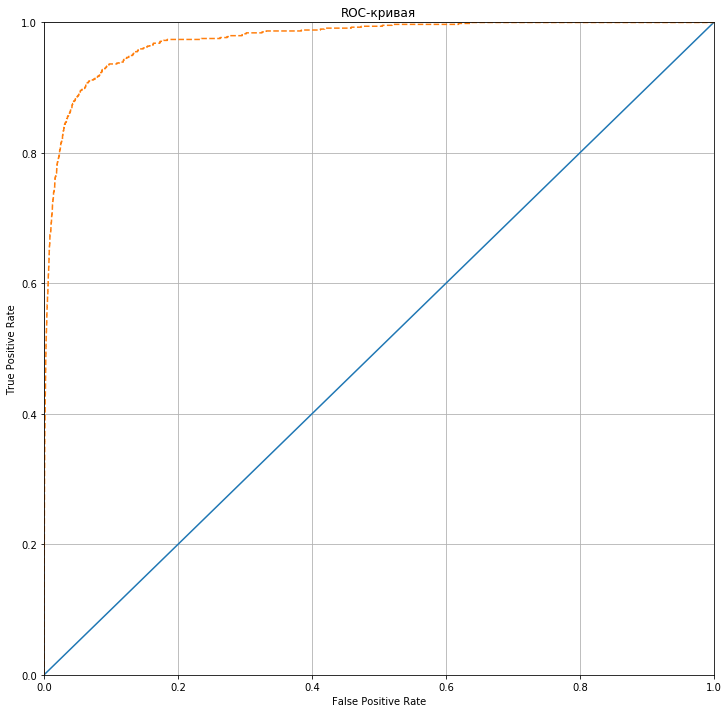

In [78]:
fpr, tpr, thresholds = roc_curve(y_valid, sgd_predict[:, 1])

plt.figure(figsize=(12, 12))
plt.plot([0, 1], [0, 1])
plt.plot(fpr, tpr, linestyle='--')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.grid(True)
plt.show()

In [79]:
%%time
param_grid = {'alpha' : [0.000001, 0.0000015, 0.000002, 0.0000025, 0.000003, 0.0000035, 0.000004, \
                         0.000005, 0.0000075, 0.00001, 0.00005]}
sgd_grid = GridSearchCV(sgd_model, param_grid, scoring='roc_auc', cv=skf, n_jobs=-1,\
                        return_train_score=True, verbose=1)
sgd_grid.fit(X_train, y)

Fitting 7 folds for each of 11 candidates, totalling 77 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:   23.6s finished


Wall time: 25 s


GridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=42, shuffle=False),
             error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='log', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=-1,
                                     penalty='l2', power_t=0.5, random_state=42,
                                     shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [1e-06, 1.5e-06, 2e-06, 2.5e-06, 3e-06,
                                   3.5e-06, 4e-06, 5e-06, 7.5e

In [80]:
def plot_validation_curves(param_values, grid_cv_results_,
                          xlabel='С', ylabel='ROC AUC'):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend()

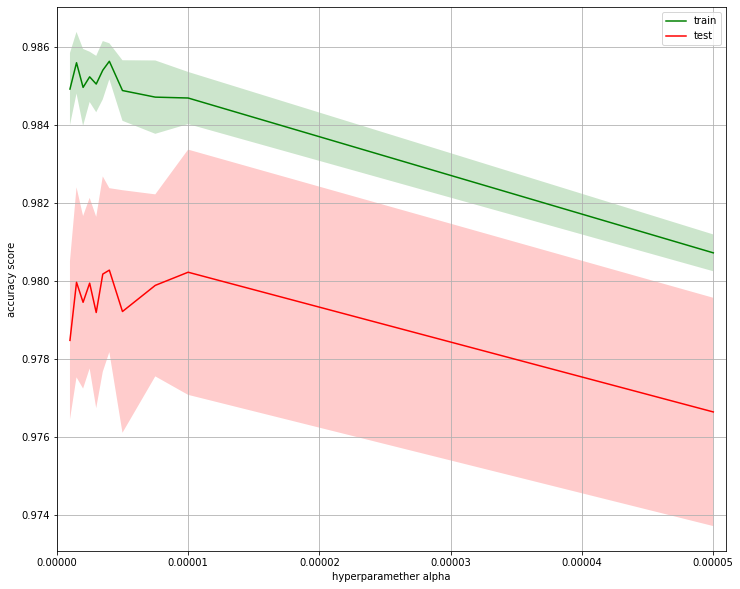

In [81]:
plt.figure(figsize=(12, 10))
plot_validation_curves(param_grid['alpha'], sgd_grid.cv_results_)
plt.xlabel('hyperparamether alpha')
plt.ylabel('accuracy score')
plt.xlim(0, 0.000051)
plt.grid(True);

In [82]:
sgd_grid.score(X_train, y)

0.984370832130649

In [83]:
sgd_grid.score(X_valid, y_valid)

0.9825382368903104

In [84]:
sgd_grid.best_params_, sgd_grid.best_estimator_

({'alpha': 4e-06}, SGDClassifier(alpha=4e-06, average=False, class_weight=None,
               early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
               l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
               n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
               random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
               verbose=0, warm_start=False))

In [106]:
sgd_final_model = SGDClassifier(loss='log', random_state=42, n_jobs=-1, alpha=4e-06)
sgd_final_model.fit(X_train, y)

SGDClassifier(alpha=4e-06, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [107]:
sgd_final_pred = sgd_final_model.predict_proba(X_test)

In [108]:
sgd_final_model.score(X_valid, y_valid)

0.9939791505080914

In [109]:
write_to_submission_file(sgd_final_pred[:, 1], 'out_sgd_final.csv')

## Часть 5.1. Будем пробовать блендинг для улучшения

Для этого проверим классификатор логистической регрессии

In [89]:
%%time
lr_model = LogisticRegression(random_state=42, n_jobs=-1)
lr_model.fit(X_train, y)

Wall time: 8.67 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=42,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [90]:
%%time
lr_params = {'C': [1, 5, 10, 15, 20, 25]}

lr_grid = GridSearchCV(estimator=lr_model, param_grid=lr_params, scoring='roc_auc', cv=skf, return_train_score=True, verbose=1, n_jobs=-1)
lr_grid.fit(X_train, y)

Fitting 7 folds for each of 6 candidates, totalling 42 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    0.0s finished


Wall time: -1.89e+10 ns


GridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=42, shuffle=False),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=-1, penalty='l2',
                                          random_state=42, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1, param_grid={'C': [1, 5, 10, 15, 20, 25]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=1)

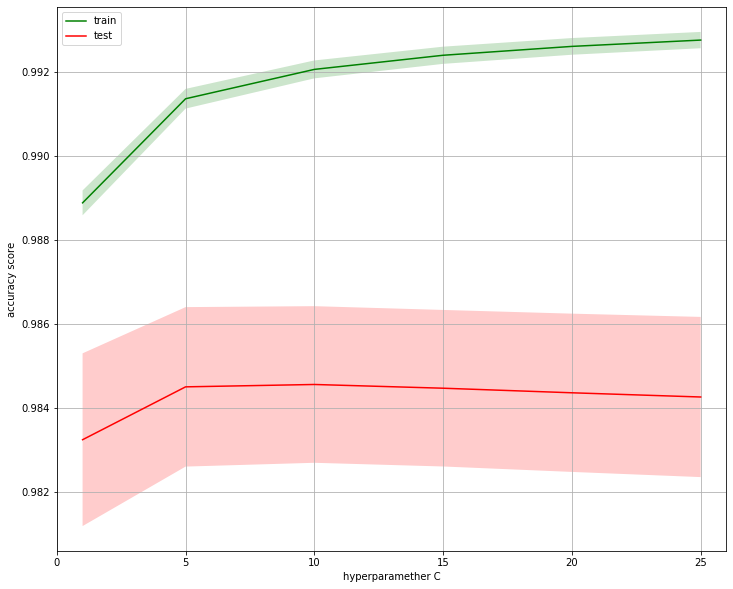

In [91]:
plt.figure(figsize=(12, 10))
plot_validation_curves(lr_params['C'], lr_grid.cv_results_)
plt.xlabel('hyperparamether C')
plt.ylabel('accuracy score')
plt.xlim(0, 26)
plt.grid(True);

In [92]:
lr_grid.score(X_valid, y_valid)

0.9914992429959584

In [93]:
lr_grid.score(X_train, y)

0.9918844670497033

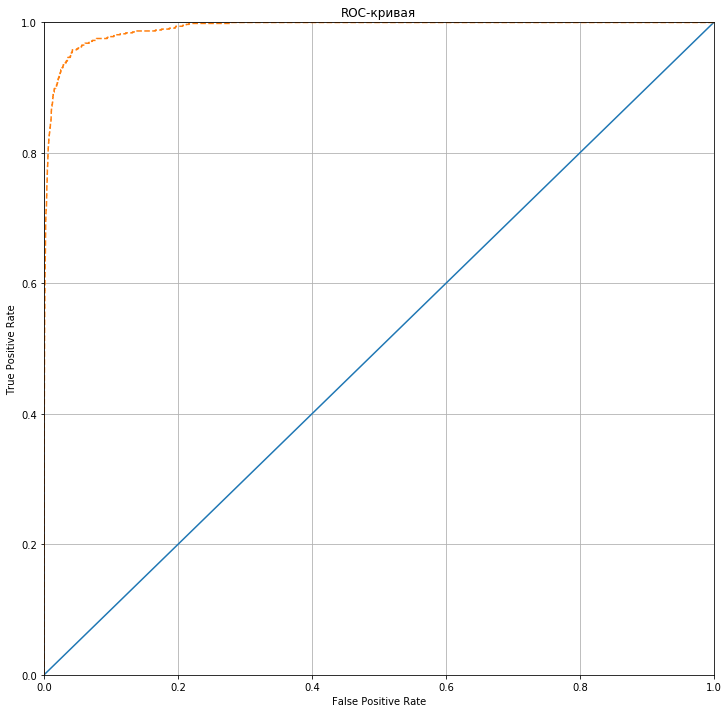

In [94]:
fpr, tpr, thresholds = roc_curve(y_valid, lr_grid.predict_proba(X_valid)[:, 1])

plt.figure(figsize=(12, 12))
plt.plot([0, 1], [0, 1])
plt.plot(fpr, tpr, linestyle='--')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.grid(True)
plt.show()

In [95]:
lr_grid.best_params_, lr_grid.best_estimator_

({'C': 10},
 LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=-1, penalty='l2', random_state=42,
                    solver='warn', tol=0.0001, verbose=0, warm_start=False))

In [96]:
%%time
lr_final_model = LogisticRegression(random_state=42, C=10)
lr_final_model.fit(X_train, y)

Wall time: 16.2 s


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [97]:
lr_final_model.score(X_valid, y_valid)

0.9949256595985224

In [98]:
lr_final_pred = lr_final_model.predict_proba(X_test)

In [99]:
write_to_submission_file(lr_final_pred[:, 1], 'out_lr_final.csv')

## Часть 5.2. Собственно сам блендинг

In [110]:
alpha = 0.5

blend = alpha * lr_final_pred[:, 1] + (1 - alpha) * sgd_final_pred[:, 1]

In [111]:
write_to_submission_file(blend, 'out_blend_final_5_lr.csv')

In [112]:
alpha = 0.55

blend = alpha * lr_final_pred[:, 1] + (1 - alpha) * sgd_final_pred[:, 1]

In [113]:
write_to_submission_file(blend, 'out_blend_final_6_lr.csv')

In [114]:
alpha = 0.45

blend = alpha * lr_final_pred[:, 1] + (1 - alpha) * sgd_final_pred[:, 1]

In [115]:
write_to_submission_file(blend, 'out_blend_final_7_lr.csv')

## Часть 6. Выводы

Начну с того что не удалось: не понял до конца как взаимодействуют разряженные данные и не разряженные (новые признаки).

Модель думаю можно допилить, понять и использовать в компаниях имеющих свои сервисы типа почты, видео или аудио хостингов, онлайн банк-клиенты и прочих где важно сохранить данные клиента. По поведению соответственно определять взломщик ли сейчас в аккаунте или нет.

Из данных наглядно можно увидеть как разделены дополнительные признаки у классах Элис и "не Элис".

**Лучшая модель - блендинг 50х50 (скор на ЛБ 0.94819) - ее результаты приложены к заданию.**